# Music Genre Classification:

## Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import scipy
import tarfile
import os
from pathlib import Path
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import subprocess
import IPython.display as ipd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import ShuffleSplit, train_test_split
from collections import defaultdict
import scikitplot
import seaborn as sns
import warnings
from python_speech_features import mfcc
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Creating Labels and MFCC Features:

In [2]:
# Generating labels.
genres_labels = dict()
cnt = 0
# Loop through each class and assign a numerical value.
for folder in os.listdir("data/genres/"):
    genres_labels[folder] = cnt
    cnt += 1
    
genres_labels

{'blues': 9,
 'classical': 2,
 'country': 7,
 'disco': 3,
 'hiphop': 6,
 'jazz': 4,
 'metal': 5,
 'pop': 1,
 'reggae': 0,
 'rock': 8}

In [3]:
# Generating MFCC Feature function.
def feature_class_generator(audio_file_path, class_name):
    # Read audio file from path provided
    rate, audio = wav.read(audio_file_path)
    
    # Get mfcc feature
    mfcc_features = mfcc(audio)
    
    # our mfcc feature contains 13 values for each frame in our audio file.
    # the total number of frames is 4100 approx value. We want to reduce this as this would overwhelm our model.
    # To do this we ignore 10% starting and 10% ending song and take mean of all the frames
    frames = mfcc_features.shape[0] # Get all frames
    mfcc_features = np.mean(mfcc_features[int(frames*0.1):int(frames*0.9)], axis = 0) # take mean
    
    # Return features and label
    return mfcc_features, genres_labels[class_name]

In [4]:
# Getting the features corresponding to each file.

features = [] # Holds features for every wav file.
labels = [] # Holds labels for every wav file.

# Loop through each folder
for folder in os.listdir("data/genres/"):
    
    # Loop through each file
    for filename in os.listdir("data/genres/"+folder+"/"):

        # Get feaure and label for the file.
        feature, label = feature_class_generator("data/genres/"+folder+"/"+filename, folder)
        
        # Store feature and label seperatly
        features.append(feature)
        labels.append(label)
        
print(len(features))
print(len(labels))

1000
1000


In [5]:
# Create a dataframe out of features and labels, shuffle them then store them.
df = pd.DataFrame(features)
df['label'] = labels
# shuffle thrice to make sure data is random.
df = shuffle(df)
df = shuffle(df)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
df.head()
df.to_pickle("MFCC_Features.pkl")
df.shape

(1000, 14)

In [6]:
df = pd.read_pickle("MFCC_Features.pkl")
labels = df['label']
df.drop(columns = ['label'], inplace=True)
label_to_genre = ['reggae', 'pop', 'classical', 'disco', 'jazz', 'metal', 'hiphop', 'country', 'rock', 'blues']

X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(700, 13)
(300, 13)
700
300


## Metric Function:

In [7]:
# this function uses heatmap of seaborn library to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    confusion_df = pd.DataFrame(data=cm, columns=label_to_genre, index=label_to_genre)
    fig1=plt.figure(figsize=(15,7))
    plt.title("Not Normalized Confusion Matrix")
    sns.heatmap(confusion_df, annot=True)
    plt.show()
    fig1.savefig(name)
    fig2=plt.figure(figsize=(15,7))
    plt.title("Normalized Confusion Matrix")
    sns.heatmap(confusion_df/confusion_df.sum(axis=1), annot=True)
    plt.show()
    fig2.savefig(name+" Normalized")

In [8]:
# this function uses the scikitplot library to plot ROC_AUC Curve.
def plot_roc_auc_curve(y_test, y_proba_pred, name):
    fig, ax = plt.subplots(figsize=(15,7))
    scikitplot.metrics.plot_roc_curve(y_test, y_proba_pred, ax=ax)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(name, bbox_inches=extent.expanded(1.1, 1.2))

##  Logistic Regression:

In [9]:
# For hyperparameter tuning.
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l2', 'l1']

# For plotting.
xticks = []
rocauc_scores = []

for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        
        # fit / Train
        lr = LogisticRegression(multi_class='ovr',C=a,penalty=p,max_iter=10000,verbose = 1,n_jobs = -1)
        lr.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = lr.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

[LibLinear]1e-05 l2:  0.8098685270637096
[LibLinear]1e-05 l1:  0.5
[LibLinear]0.0001 l2:  0.8310721077880366
[LibLinear]0.0001 l1:  0.5
[LibLinear]0.001 l2:  0.8449823505567517
[LibLinear]0.001 l1:  0.6041357218694354
[LibLinear]0.01 l2:  0.8436730686438437
[LibLinear]0.01 l1:  0.8366299384316861
[LibLinear]0.1 l2:  0.8430839019830927
[LibLinear]0.1 l1:  0.8470358388784135
[LibLinear]1 l2:  0.8469921960365617
[LibLinear]1 l1:  0.8526290965677461
[LibLinear]10 l2:  0.855108332484973
[LibLinear]10 l1:  0.8591876569495863
[LibLinear]100 l2:  0.8587185777700059
[LibLinear]100 l1:  0.859608778598232
[LibLinear]1000 l2:  0.8595267908119737
[LibLinear]1000 l1:  0.8595678780083574


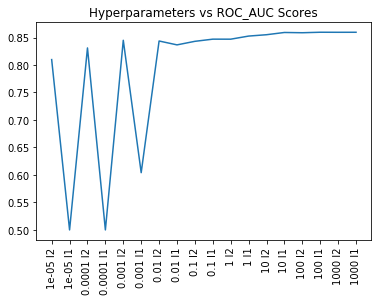

In [10]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("LR_MFCC_hyperparameters_vs_roc_auc")

In [11]:
# Training the Model with best parameters found.
C = 1000 # From graph.
p = 'l2' # From graph.
lr = LogisticRegression(C=C, penalty=p, solver='liblinear', multi_class='ovr', max_iter=10000, n_jobs = -1)
lr.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=-1, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

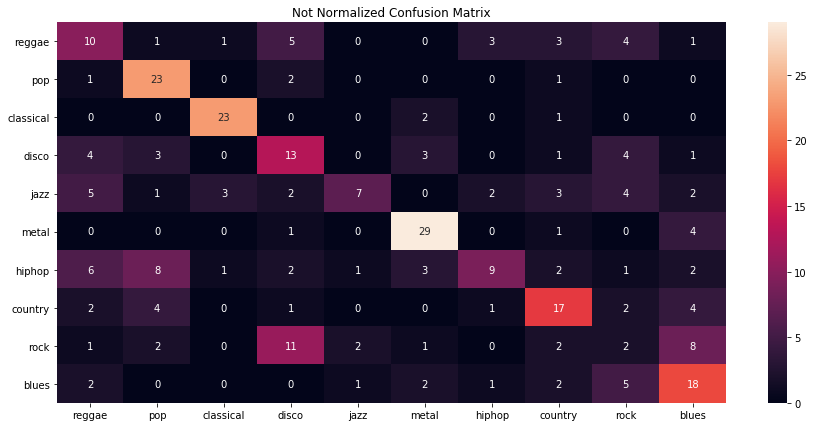

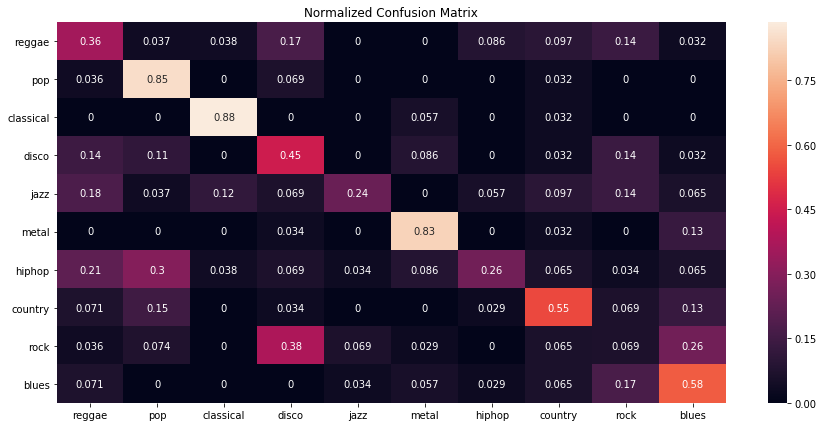

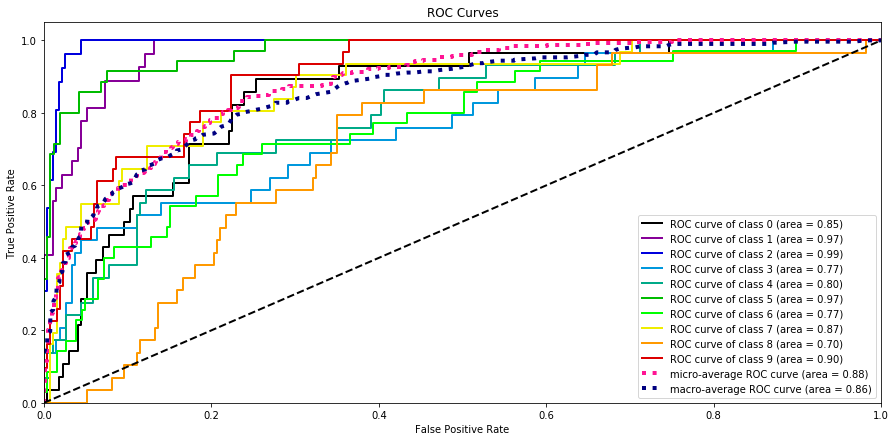

In [12]:
# Getting the confusion matrix.
y_pred = lr.predict(X_test)
y_proba_pred = lr.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "LR_MFCC_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "LR_MFCC_ROC_AUC_Curve")

## RanomForest:

In [13]:
# Hyperparameters:
n_estimators = [30, 50, 100, 300, 500]
max_depth = [3, 5, 7]

# For plotting.
xticks = []
rocauc_scores = []

for estim in n_estimators:
    for dep in max_depth:
        xticks.append("Estimators:" + str(estim) + ' MaxDepth:' + str(dep))
        
        # fit / Train
        rf = RandomForestClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
        rf.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = rf.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

Estimators:30 MaxDepth:3:  0.8300939767259845
Estimators:30 MaxDepth:5:  0.8597978507527717
Estimators:30 MaxDepth:7:  0.8817650007572571
Estimators:50 MaxDepth:3:  0.8404015153742839
Estimators:50 MaxDepth:5:  0.8722900925404726
Estimators:50 MaxDepth:7:  0.8820016565783311
Estimators:100 MaxDepth:3:  0.8459387264827452
Estimators:100 MaxDepth:5:  0.8702619664190069
Estimators:100 MaxDepth:7:  0.891415551085019
Estimators:300 MaxDepth:3:  0.8529190258975996
Estimators:300 MaxDepth:5:  0.8807972462846699
Estimators:300 MaxDepth:7:  0.8908443957254606
Estimators:500 MaxDepth:3:  0.8539822677329102
Estimators:500 MaxDepth:5:  0.8825059815543845
Estimators:500 MaxDepth:7:  0.8925173078326332


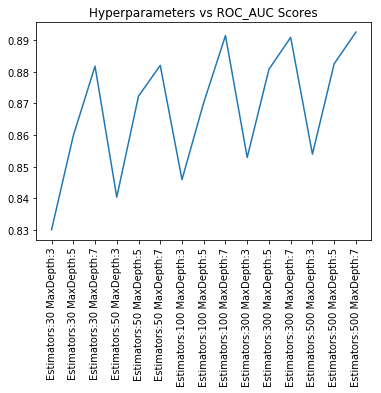

In [14]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("RF_MFCC_Hyperparameters_vs_roc_auc")

In [15]:
# Training the Model with best parameters found.
estim = 300 # From graph.
dep = 7 # From graph.
rf = RandomForestClassifier(n_estimators=estim, max_depth=dep)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

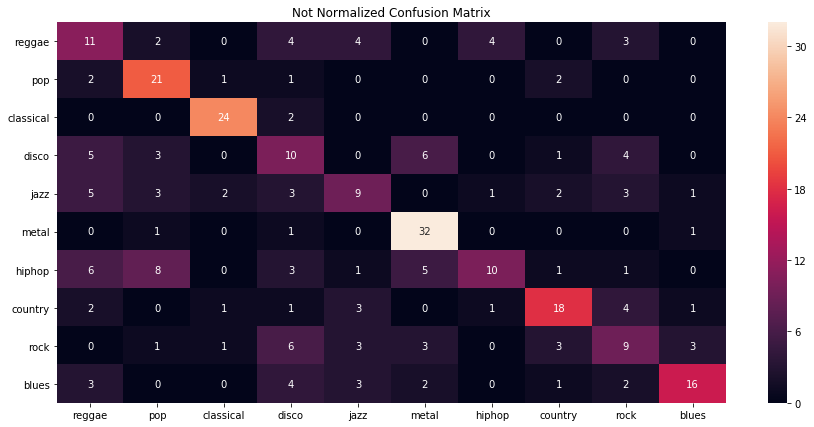

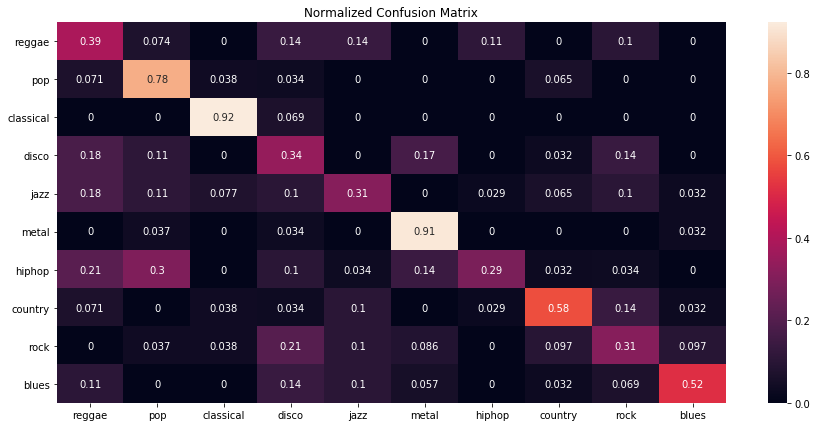

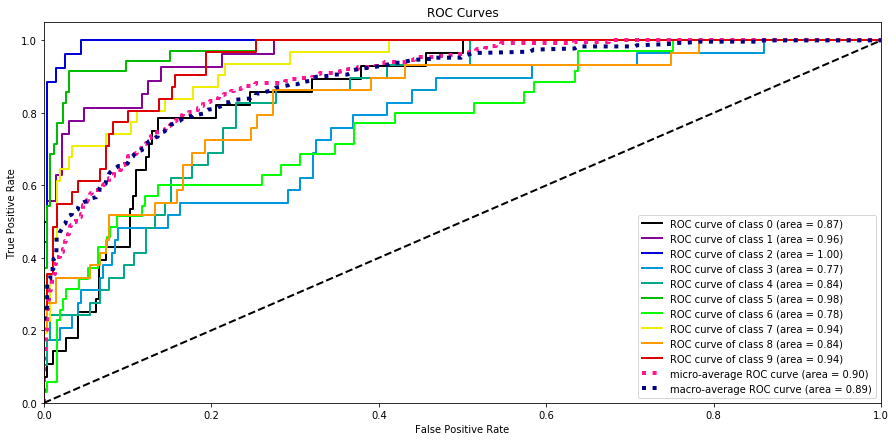

In [17]:
# Getting the confusion matrix.
y_pred = rf.predict(X_test)
y_proba_pred = rf.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "RF_MFCC_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "RF_MFCC_ROC_AUC_Curve")

## XGBClassifier:

In [18]:
# Hyperparameters:
n_estimators = [30, 50, 100, 300, 500]
max_depth = [3, 5, 7]

# For plotting.
xticks = []
rocauc_scores = []

for estim in n_estimators:
    for dep in max_depth:
        xticks.append("Estimators:" + str(estim) + ' MaxDepth:' + str(dep))
        
        # fit / Train
        xgbcf = XGBClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
        xgbcf.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = xgbcf.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

Estimators:30 MaxDepth:3:  0.8597252171011016
Estimators:30 MaxDepth:5:  0.8658797784643797
Estimators:30 MaxDepth:7:  0.8618229112093182
Estimators:50 MaxDepth:3:  0.8668657313149556
Estimators:50 MaxDepth:5:  0.8705477024919042
Estimators:50 MaxDepth:7:  0.8718884998797568
Estimators:100 MaxDepth:3:  0.8743501061991064
Estimators:100 MaxDepth:5:  0.8742098940776165
Estimators:100 MaxDepth:7:  0.8751687363572141
Estimators:300 MaxDepth:3:  0.8757963945119226
Estimators:300 MaxDepth:5:  0.874826428950634
Estimators:300 MaxDepth:7:  0.8764811129534122
Estimators:500 MaxDepth:3:  0.8741449380147628
Estimators:500 MaxDepth:5:  0.8759700230752617
Estimators:500 MaxDepth:7:  0.8777320121421903


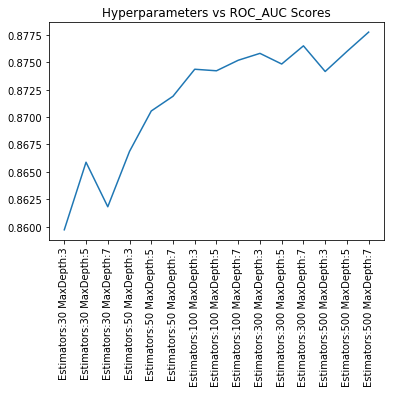

In [19]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("XgBoost_MFCC_Hyperpaameters_vs_roc_auc")

In [20]:
# Training the Model with best parameters found.
estim = 500 # From graph.
dep = 5 # From graph.
xgbcf = XGBClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
xgbcf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

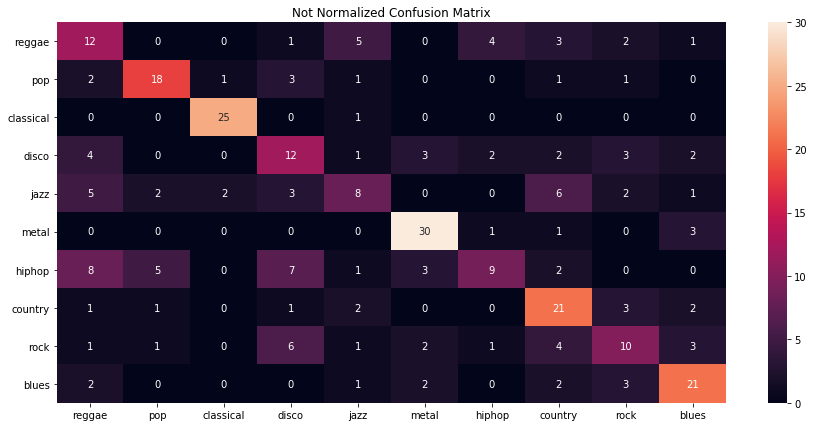

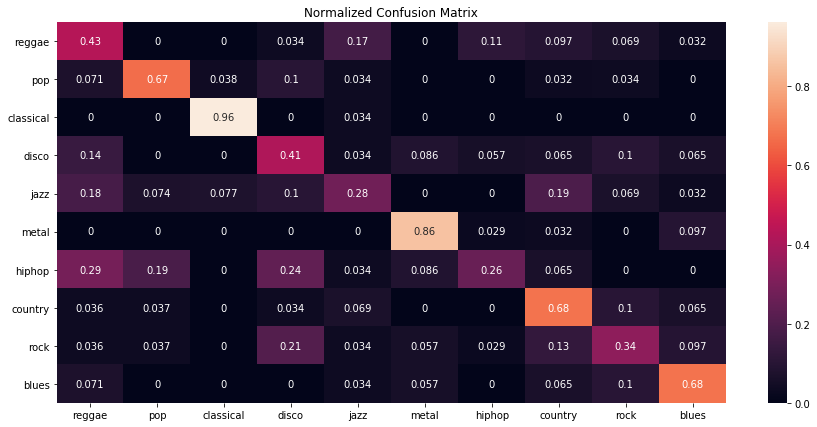

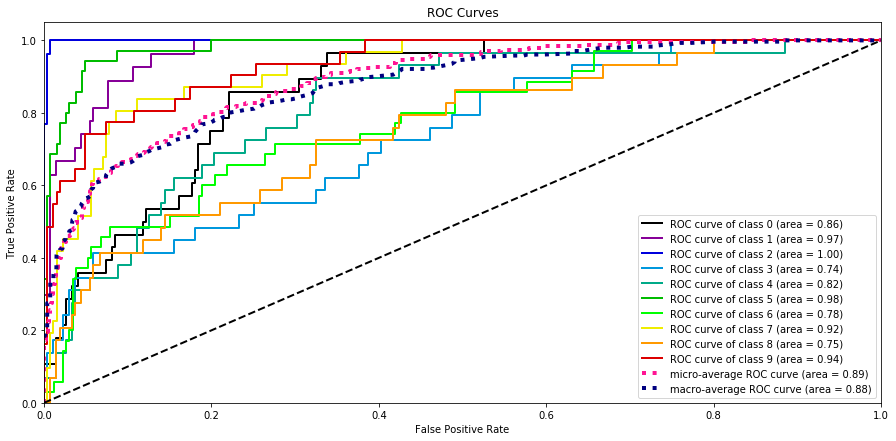

In [21]:
# Getting the confusion matrix.
y_pred = xgbcf.predict(X_test)
y_proba_pred = xgbcf.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "XgBoost_MFCC_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "XgBoost_MFCC_ROC_AUC_Curve")